In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [ ]:
# !wget https://tlk.s3.yandex.net/course/shad_cv_project_22/dataset_students.zip
# unzip dataset_students.zip


In [3]:
import pytorch_lightning as pl

In [4]:
import pandas as pd
import ipyplot
import torch
import pytorch_lightning as pl
from sklearn.metrics import f1_score
%matplotlib inline

In [5]:
from src.model import ImageClassifier
from src.utils import ImagesDataset, evaluate_model
from src.transforms import transform
from src import params

In [6]:
!nvidia-smi

Sat Oct  8 07:53:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:00:05.0 Off |                    0 |
| N/A   34C    P0    42W / 250W |   2073MiB / 32510MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  Off  | 00000000:00:06.0 Off |                    0 |
| N/A   

# Load dataset

In [7]:
# train_df = pd.read_csv('dataset_students/classification/train_labelled.csv')
# train_df.head()

train_df = pd.read_csv('aggregated_results_by_ds__pool_35739415__2022_10_05.tsv', sep='\t', index_col=None)
train_df.head()

,INPUT:image,OUTPUT:result,CONFIDENCE:result
0,labelled/20.png,yes,100.00%
1,labelled/94.png,yes,100.00%
2,labelled/54.png,other,100.00%
3,labelled/23.png,other,100.00%
4,labelled/112.png,other,100.00%


In [8]:
train_df['INPUT:image'] = 'dataset_students/classification/train_unlabelled/' + train_df['INPUT:image'].str.split('/').apply(lambda x: x[1])
train_df

,INPUT:image,OUTPUT:result,CONFIDENCE:result
0,dataset_students/classification/train_unlabell...,yes,100.00%
1,dataset_students/classification/train_unlabell...,yes,100.00%
2,dataset_students/classification/train_unlabell...,other,100.00%
3,dataset_students/classification/train_unlabell...,other,100.00%
4,dataset_students/classification/train_unlabell...,other,100.00%
...,...,...,...
2043,dataset_students/classification/train_unlabell...,no,100.00%
2044,dataset_students/classification/train_unlabell...,no,99.99%
2045,dataset_students/classification/train_unlabell...,other,100.00%
2046,dataset_students/classification/train_unlabell...,no,100.00%


<AxesSubplot:>

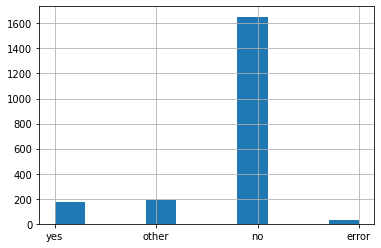

In [9]:
train_df['OUTPUT:result'].hist()

In [10]:
train_df['OUTPUT:result'] = train_df['OUTPUT:result'].map(dict(yes=1, no=0, other=2, error=2)).astype(int)

<AxesSubplot:>

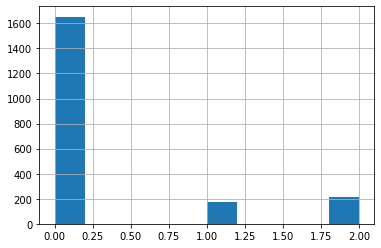

In [11]:
train_df['OUTPUT:result'].hist()

In [60]:
# train_image_paths = train_df.img_path.values
# train_labels = train_df.label.values


train_image_paths = train_df['INPUT:image'].values
train_labels = train_df['OUTPUT:result'].values

In [13]:
len(train_image_paths)

2048

In [14]:
ipyplot.plot_class_tabs(train_image_paths, train_labels, max_imgs_per_tab = 10)

# Prepare model

In [31]:
train_dataset = ImagesDataset(train_image_paths, train_labels, transform=transform)

In [32]:
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=params.BATCH_SIZE,
                                           num_workers=16,
                                           shuffle=False)

In [38]:
# Run macos_cert_fix.py if you are getting ssl errors
model = ImageClassifier(learning_rate=params.LEARNING_RATE)

In [40]:
logger = pl.loggers.TensorBoardLogger("tb_logs", name="init_model_2000",)


trainer = pl.Trainer(
    max_epochs=params.MAX_EPOCHS,
    log_every_n_steps=1, # Change to enable tensorboard logging
    gpus=1, # Uncomment to use GPU training
)
trainer.fit(model, train_loader)

/home/alekseyen/miniconda3/envs/py39/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/alekseyen/miniconda3/envs/py39/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:107: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type         | Params
---------------------------------------
0 | trunk | EfficientNet | 2.2 M 
---------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.91

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [35]:
trainer.logger.log_dir

'tb_logs/init_model_2000/version_8'

In [36]:
!ls tb_logs/init_model_2000/version_7

checkpoints  hparams.yaml


In [37]:
trainer.logged_metrics

{'loss': tensor(0.0019)}

# Compute training set accuracy

In [47]:
labels, predictions, probas, idxs = evaluate_model(model, train_dataset)

  0%|          | 0/64 [00:00<?, ?it/s]

In [42]:
ipyplot.plot_class_tabs(train_image_paths[idxs], predictions,)

In [43]:
predictions = [0 if x == 2 else x for x in predictions ]
labels = [0 if x == 2 else x for x in labels ]

In [44]:
f1_score(labels, predictions, labels=1, average='binary')

0.8771929824561403

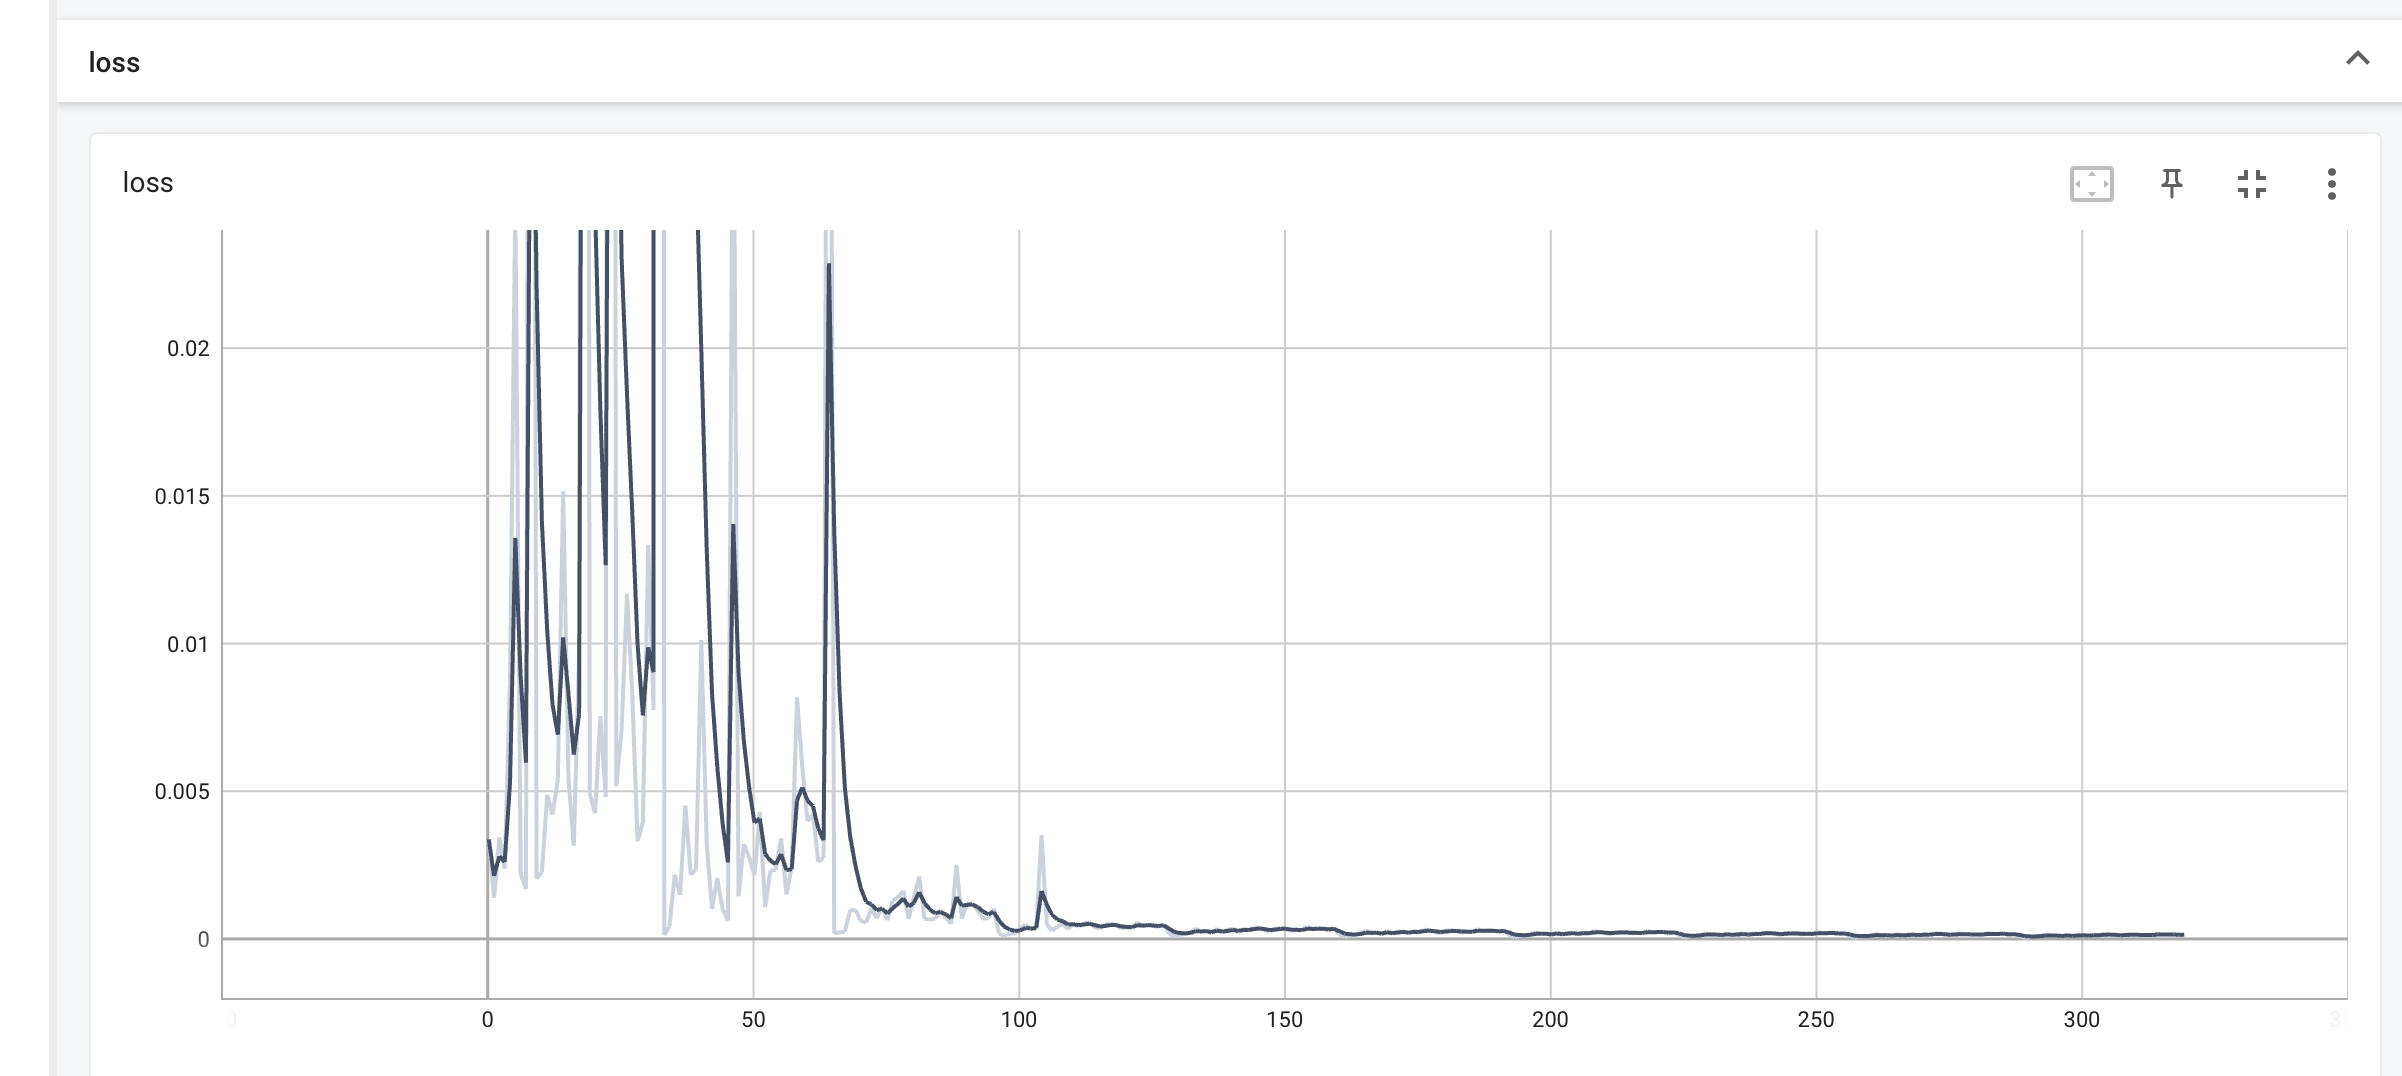

## Evaluate on full

In [59]:
import os

full_image_paths = []

dataset_dir = 'dataset_students/classification/train_unlabelled'

for file in os.listdir(dataset_dir):
    if file.endswith(".png"):
        full_image_paths += [os.path.join(dataset_dir, file)]


len(full_image_paths)

8500

In [77]:
import numpy as np
other_part_path = np.array(list(set(full_image_paths) - set(train_image_paths)))

len(other_part_path)

6500

In [72]:
other_part_dataset = ImagesDataset(other_part_path, transform=transform)

labels, predictions, probas, idxs = evaluate_model(model, other_part_dataset)

  0%|          | 0/204 [00:00<?, ?it/s]

In [80]:
df = pd.DataFrame(dict(idxs=idxs, file_path = other_part_path[idxs], probas=probas, predictions=predictions))

df.head(10)

,idxs,file_path,probas,predictions
0,tensor(0),dataset_students/classification/train_unlabell...,"[tensor(0.0190), tensor(0.9792), tensor(0.0018)]",1
1,tensor(1),dataset_students/classification/train_unlabell...,"[tensor(0.9997), tensor(0.0003), tensor(2.0569...",0
2,tensor(2),dataset_students/classification/train_unlabell...,"[tensor(1.0000), tensor(1.9524e-06), tensor(9....",0
3,tensor(3),dataset_students/classification/train_unlabell...,"[tensor(0.8721), tensor(2.6210e-06), tensor(0....",0
4,tensor(4),dataset_students/classification/train_unlabell...,"[tensor(0.0430), tensor(0.9570), tensor(2.2035...",1
5,tensor(5),dataset_students/classification/train_unlabell...,"[tensor(0.9819), tensor(0.0178), tensor(0.0002)]",0
6,tensor(6),dataset_students/classification/train_unlabell...,"[tensor(0.9372), tensor(0.0623), tensor(0.0005)]",0
7,tensor(7),dataset_students/classification/train_unlabell...,"[tensor(0.9995), tensor(0.0005), tensor(7.9354...",0
8,tensor(8),dataset_students/classification/train_unlabell...,"[tensor(1.0000), tensor(1.1067e-07), tensor(3....",0
9,tensor(9),dataset_students/classification/train_unlabell...,"[tensor(0.6901), tensor(0.0021), tensor(0.3078)]",0


In [84]:
df['max_prob'] = df.probas.apply(lambda x: x.max())

In [87]:
df.sort_values(by='max_prob').head(3700).to_csv('most_unconfident.csv') # сортим так, чтобы разметить 3700 объектов в которых мы менее всего уверны

# Save model

In [45]:
trainer.save_checkpoint("model.ckpt")